## **RADI605: Modern Machine Learning**

### Assignment: Random Forests
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

From the given data, create a random forest with $T=3$, OOB rate = $20\%$, and initialize any additional parameters that may be needed.

| Sample M  | Gene #1       | Gene #2         | Gene #3         | Class           |
|:---------:|---------------|-----------------|-----------------|-----------------|
| 1         | -3            | 1               | 6               | 1               |
| 2         | 3             | -1              | 6               | 1               |
| 3         | 6             | 1               | 12              | 1               |
| 4         | 1             | 0               | 2               | -1              |
| 5         | 0             | 1               | 0               | -1              |

Out of the total number of samples in the data, 20% of the samples will be left out for Out-of-Bag (OOB) error calculation. So, for the given data with 5 samples, we will have 1 sample as OOB. Then, the original data will be bootstrapped to create $T = 3$ bootstrapped datasets. Suppose our OOB sample is sample 4:

| Sample M  | Gene #1       | Gene #2         | Gene #3         | Class           |
|:---------:|---------------|-----------------|-----------------|-----------------|
| 4         | 1             | 0               | 2               | -1              |

Bootstrapping: To create $T = 3$ bootstrapped datasets, we will randomly sample with replacement from the original data T times. Each bootstrapped dataset will have the same number of samples as the original data. Suppose bootstrapped dataset $D_1$ is the following:

| Sample M  | Gene #1       | Gene #2         | Gene #3         | Class           |
|:---------:|---------------|-----------------|-----------------|-----------------|
| 1         | -3            | 1               | 6               | 1               |
| 2         | 3             | -1              | 6               | 1               |
| 4         | 1             | 0               | 2               | -1              |
| 5         | 0             | 1               | 0               | -1              |
| 4         | 1             | 0               | 2               | -1              |

To calculate the Gini index and Gini gain for bootstrapped $D_1$, we will first calculate the Gini index for each feature (Gene #1, Gene #2, Gene #3) and use the Gini gain to determine the best feature to split the data at the root node.

### Root Node: The Gini index measures the impurity of a set of samples. For a binary classification problem, the Gini index can be calculated as follows:

\begin{equation*}
\begin{aligned}
    \text{Gini}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                        &= 1 - (0.4)^2 - (0.4)^2 \\
                        &= 1 - 0.32 \\
    \text{Gini}(D_1)    &= 0.48
\end{aligned}
\end{equation*}

Calculate the gini gain for each feature, which is the reduction in the gini index after splitting the data on the feature. For example, if we split the data on Gene #1, we would get two subsets of the data: one subset where Gene #1 is less than a threshold and another subset where Gene #1 is greater than the threshold. To calculate gini gain, we need to calculate the weighted average of the gini indices of the two subsets, where the weights are the proportions of samples in each subset. 

### Splits on Gene #1
Next, we'll calculate the gini gain for Gene #1. The split on Gene #1 is -3.
- $\text{Class 1}  \rightarrow \frac{0}{1} = 0$ and $\text{Class -1} \rightarrow \frac{1}{1} = 1 $

Therefore, 
\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                              &= 1 - (0)^2 - (1)^2 \\
                              &= 1 - 1 \\
    \text{Gini index split}(D_1)    &= 0
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini Gain split}(D_1)    &= \text{Gini}(D_1) - \sum_{i = 1}^{n} \frac{|D_{1i}|}{|D_1|} \text{Gini}(D_1i)\\
                                   &= 0.48 - (1/5) \cdot 0 - (4/5) \cdot 0.48 \\
    \text{Gini Gain split}(D_1)    &= 0.24
\end{aligned}
\end{equation*}

We'll repeat the calculation for the gini gain for Gene #1 where the split on Gene #1 is 3.
- $\text{Class 1}  \rightarrow \frac{1}{2} = 0.5$ and $\text{Class -1} \rightarrow \frac{0}{2} = 0 $

Therefore, 
\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (0.5)^2 - (0)^2 \\
    \text{Gini index split}(D_1)    &= 0.5
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini Gain split}(D_1)    &= \text{Gini}(D_1) - \sum_{i = 1}^{n} \frac{|D_{1i}|}{|D_1|} \text{Gini}(D_1i)\\
                                   &= 0.48 - (2/5) \cdot 0 - (3/5) \cdot 0.48 \\
    \text{Gini Gain split}(D_1)    &= 0.072
\end{aligned}
\end{equation*}

Finally, calculate the gini gain for Gene #1 where the split on Gene #1 is 1.
- $\text{Class 1}  \rightarrow \frac{1}{2} = 0.5$ and $\text{Class -1} \rightarrow \frac{1}{2} = 0.5 $

Therefore, 
\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (0.5)^2 - (0.5)^2 \\
    \text{Gini index split}(D_1)    &= 0.5
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini Gain split}(D_1)    &= \text{Gini}(D_1) - \sum_{i = 1}^{n} \frac{|D_{1i}|}{|D_1|} \text{Gini}(D_1i)\\
                                   &= 0.48 - (2/5) \cdot 0.5 - (3/5) \cdot 0.48 \\
    \text{Gini Gain split}(D_1)    &= 0.072
\end{aligned}
\end{equation*}

The split for value 0 in Gene #1 was not included because, in the calculation of gini gain, it resulted in a negative gain value. The CART algorithm used in Random Forest only chooses the split that results in the highest positive gain value. As a result, a split for value 0 in Gene #1 was not included. Since Gene #1 has the highest gini gain when split on value = $-3$, we'll use that split for the root of the tree.
The tree would look like:

                                                (Gene #1 <= 1.5)
                                                         |
                                                         |
                                _________________________|________________________
                               |                                                  |
                               |                                                  |
                       (Gene #3 <= 5.5)                                     (Gene #3 > 5.5)
                               |                                                  |
                               |                                                  |
                     __________|__________                                        |
                    |                     |                                       |
                    |                     |                                       |
              (Class = -1)          (Class = 1)                              (Class = 1)


### Splits on Gene #2
Next, we'll calculate the gini gain for Gene #2. The split on Gene #2 is -1.

\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (0.75)^2 - (0.25)^2 \\
    \text{Gini index split}(D_1)    &= 0.375
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (0.50)^2 - (0.50)^2 \\
    \text{Gini index split}(D_1)    &= 0.50
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini Gain split}(D_1)    &= \text{Gini}(D_1) - \sum_{i = 1}^{n} \frac{|D_{1i}|}{|D_1|} \text{Gini}(D_1i)\\
                                   &= 0.375 - (4/8) \cdot 0.375 - (4/8) \cdot 0.50 \\
    \text{Gini Gain split}(D_1)    &= 0.0625
\end{aligned}
\end{equation*}

The split on Gene #2 is 1.

\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (0.67)^2 - (0.33)^2 \\
    \text{Gini index split}(D_1)    &= 0.444
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (0.40)^2 - (0.60)^2 \\
    \text{Gini index split}(D_1)    &= 0.48
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini Gain split}(D_1)    &= \text{Gini}(D_1) - \sum_{i = 1}^{n} \frac{|D_{1i}|}{|D_1|} \text{Gini}(D_1i)\\
                                   &= 0.44444444 - (3/8) \cdot 0.44444444 - (5/8) \cdot 0.44444444 \\
    \text{Gini Gain split}(D_1)    &= 0.01111111
\end{aligned}
\end{equation*}


                                                (Gene #2 <= 0.5)
                                                         |
                                                         |
                                _________________________|___________________________
                               |                                                     |
                               |                                                     |
                        (Gene #3 <= 5.5)                                     (Gene #3 > 5.5)
                               |                                                     |
                               |                                                     |
                     __________|__________                                           |
                    |                     |                                          |
                    |                     |                                          |
               (Class = 1)           (Class = -1)                              (Class = 1)


### Splits on Gene #3
Finally, we'll calculate the gini gain for Gene #3. The split on Gene #3 is 2.

\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (1.0)^2 - (0)^2 \\
    \text{Gini index split}(D_1)    &= 0
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini index split}(D_1)    &= 1 - \sum_{j = 1}^{L}p^2_j \\
                                    &= 1 - (1.0)^2 - (0)^2 \\
    \text{Gini index split}(D_1)    &= 0
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \text{Gini Gain split}(D_1)    &= \text{Gini}(D_1) - \sum_{i = 1}^{n} \frac{|D_{1i}|}{|D_1|} \text{Gini}(D_1i)\\
                                   &= 0 - (2/8) \cdot 0 - (6/8) \cdot 0.48 \\
    \text{Gini Gain split}(D_1)    &= -0.12
\end{aligned}
\end{equation*}


The highest gini gain was obtained from Gene #2 with a split at -1, so the first split of the tree will be based on Gene #2 and split at -1.

                                                (Gene #3 <= 5.5)
                                                         |
                                                         |
                                _________________________|____________________________
                               |                                                      |
                               |                                                      |
                       (Gene #2 <= 0.5)                                     (Gene #2 > 0.5)
                               |                                                      |
                               |                                                      |
                     __________|__________                                            |
                    |                     |                                           |
                    |                     |                                           |
              (Class = -1)           (Class = 1)                                (Class = 1)


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from numpy import mean
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_learning_curves
from statsmodels.stats.outliers_influence import variance_inflation_factor
from time import time

import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
def convert_binary(df, columns = ['Risk1Yr']):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x == 'F' else 1)
    return df

def load_thoracic(path = '../data/ThoraricSurgery.csv'):
    data = pd.read_csv(path)
    data = data[data.columns[2:]]
    data = data.drop(['PRE6', 'PRE14'], axis = 1)
    label_columns = data.columns[2:12]
    data = convert_binary(data, columns = ['Risk1Yr'])
    data = convert_binary(data, columns = label_columns)
    include_columns = data.columns[0:-1]
    X, y = data[include_columns], data['Risk1Yr']
    X, y = X.to_numpy(), y.to_numpy()
    y[y == 0] = -1
    return X, y, data

X, y, data = load_thoracic()

In [4]:
data.columns.values 

array(['PRE4', 'PRE5', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17',
       'PRE19', 'PRE25', 'PRE30', 'PRE32', 'AGE', 'Risk1Yr'], dtype=object)

In [5]:
describe = pd.DataFrame(data.describe())
mean, std = describe.iloc[1], describe.iloc[2]
describe.loc['cv'] = std / mean
describe

,PRE4,PRE5,PRE7,PRE8,PRE9,PRE10,PRE11,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,3.281638,4.568702,0.065957,0.144681,0.065957,0.687234,0.165957,0.074468,0.004255,0.017021,0.821277,0.004255,62.534043,-0.702128
std,0.871395,11.767857,0.248472,0.352154,0.248472,0.464114,0.372439,0.262811,0.065163,0.129488,0.383529,0.065163,8.706902,0.712810
min,1.440000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,-1.000000
25%,2.600000,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,57.000000,-1.000000
50%,3.160000,2.400000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,62.000000,-1.000000
75%,3.807500,3.080000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.000000,-1.000000
max,6.300000,86.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87.000000,1.000000
cv,0.265537,2.575755,3.767159,2.434003,3.767159,0.675336,2.244183,3.529174,15.313358,7.607439,0.466991,15.313358,0.139235,-1.015214


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PRE4     470 non-null    float64
 1   PRE5     470 non-null    float64
 2   PRE7     470 non-null    int64  
 3   PRE8     470 non-null    int64  
 4   PRE9     470 non-null    int64  
 5   PRE10    470 non-null    int64  
 6   PRE11    470 non-null    int64  
 7   PRE17    470 non-null    int64  
 8   PRE19    470 non-null    int64  
 9   PRE25    470 non-null    int64  
 10  PRE30    470 non-null    int64  
 11  PRE32    470 non-null    int64  
 12  AGE      470 non-null    int64  
 13  Risk1Yr  470 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 51.5 KB


When features are highly correlated, they contain redundant information, and the Random Forest may use the same feature in many of the trees, leading to overfitting. Additionally, highly correlated features can cause instability in the feature importance scores and make it difficult to interpret the results.

It's always a good idea to check for highly correlated features before training a Random Forest and remove or combine them as needed. This can be done using techniques such as principal component analysis (PCA) or feature selection. By reducing the number of highly correlated features, you can simplify the model and make it more interpretable, and you may also see an improvement in performance.


<AxesSubplot:>

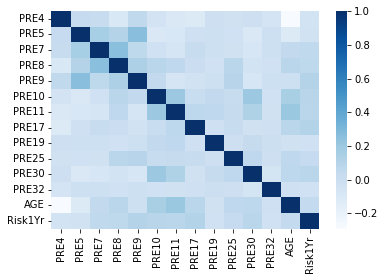

In [7]:
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(),cmap = 'Blues', annot = False) 

In [8]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif['Features'] = data.columns
vif.sort_values(by = 'VIF', ascending = False)

,VIF,Features
12,15.782380,AGE
0,10.629432,PRE4
10,5.858002,PRE30
5,3.558516,PRE10
13,2.058501,Risk1Yr
6,1.324056,PRE11
3,1.317850,PRE8
1,1.286707,PRE5
4,1.217552,PRE9
2,1.193499,PRE7


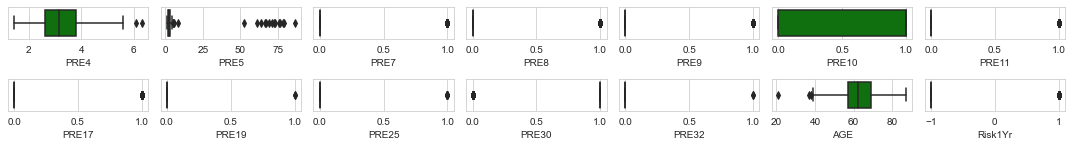

In [10]:
l = data.columns.values
number_of_columns = 7
number_of_rows = data.shape[0]
plt.figure(figsize = (15, 1 * number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1, number_of_columns, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data[l[i]], color = 'green', orient = 'v')
    plt.tight_layout()

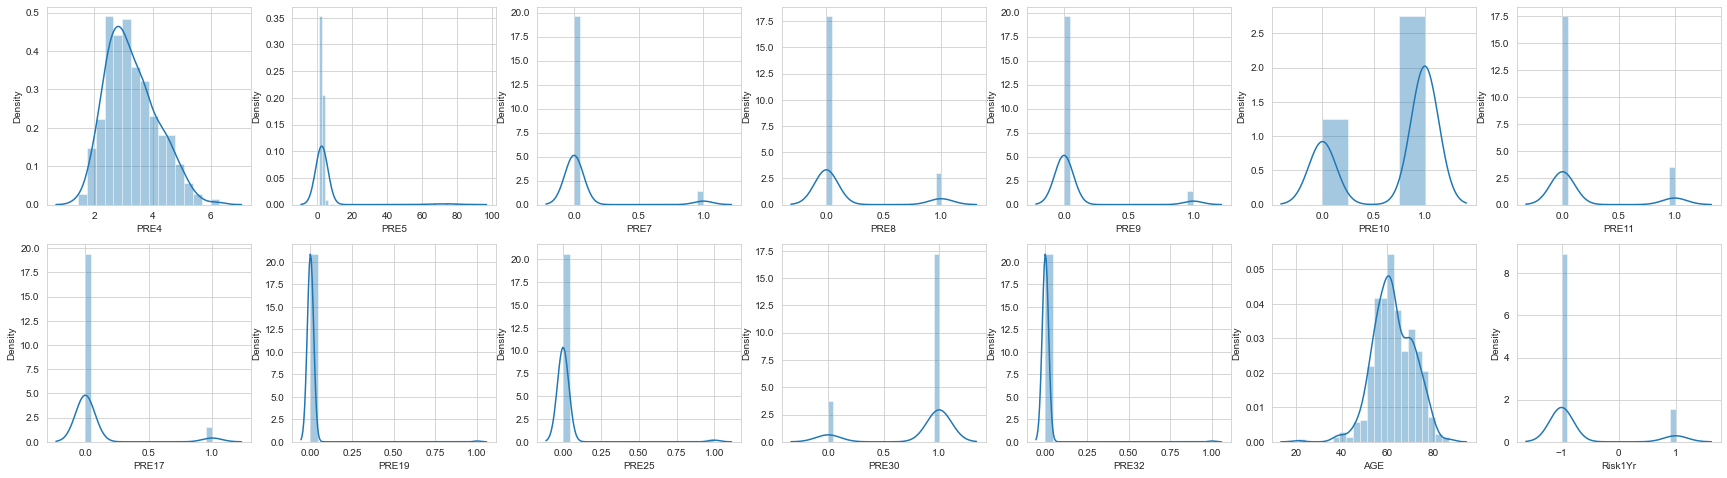

In [16]:
plt.figure(figsize = (30, 8))
for i in range(0, len(l)):
    plt.subplot(2, 7, i + 1)
    sns.set_style('whitegrid')
    sns.distplot(data[l[i]], kde = True) 
    plt.tight_layout

The barplot below shows the the Thoracic Surgery dataset is imbalanced (i.e., distribution of the classes is unequal, with one or more classes being underrepresented.). This may lead to biased or unreliable results if the machine learning model is not trained to account for the imbalance in the data. One way to overcome this problem is to adopt resampling techniques to the training data. However, we can check the original dataset first if it can already provide good model performance on unseen dataset.

Text(0.5, 1.0, 'Imbalanced dataset')

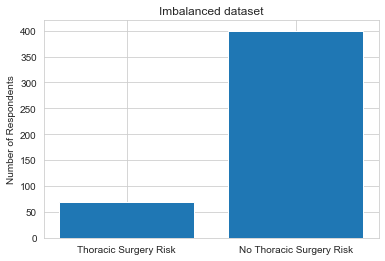

In [19]:
x = np.arange(2)
plt.bar(x, height = [len(y[y == 1]), len(y[y == -1])])
plt.xticks(x, ['Thoracic Surgery Risk', 'No Thoracic Surgery Risk'])
plt.ylabel('Number of Respondents')
plt.title('Imbalanced dataset')

In [3]:
def convert_binary(df, columns = ['Risk1Yr']):
    for column in columns:
        df[column] = df[column].apply(lambda x: -1 if x == 'F' else 1)
    return df

def load_thoracic(path = '../data/ThoraricSurgery.csv'):
    data = pd.read_csv(path)
    data = data[data.columns[2:]]
    data = data.drop(['PRE6', 'PRE14'], axis = 1)
    label_columns = data.columns[2:12]
    data = convert_binary(data, columns = ['Risk1Yr'])
    data = convert_binary(data, columns = label_columns)
    include_columns = data.columns[0:-1]
    X, y = data[include_columns], data['Risk1Yr']
    X, y = X.to_numpy(), y.to_numpy()
    y[y == 0] = -1
    return X, y, data

def split_data(X, y, pca_included = False, smote_included = False):
    print('Model Assumptions:')
    if pca_included is True:
        print('\t The dataset used PCA for dimensionality reduction.')
        pca = PCA(n_components = 8)
        X = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    if smote_included is True:
        print('\t The dataset used SMOTE to rectify class imbalance.')
        smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 5, random_state = 42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    else:
        print('\t The dataset did NOT use SMOTE.')
        X_resampled, y_resampled = X_train, y_train 
    scaler  = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test  = scaler.transform(X_test)
    return X_resampled, y_resampled, X_test, y_test

def init_parameters():
    param_grid = { 
                'n_estimators': [10, 2000], 
                'criterion': ['gini', 'entropy'],
                'max_depth': np.arange(1, 20),
                'min_samples_split': np.arange(1, 5)
              }
    return param_grid

def validation(rsearch, X_test, y_test):
    predictions = rsearch.predict(X_test)
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    return predictions

def train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = False, print_params = True):
    param_grid = init_parameters()
    if use_randomsearch is True:
        print('\t This model has been cross-validated through Random Search.')
        rsearch = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                                     param_distributions = param_grid, 
                                     cv = 10, n_iter = 10)
        rsearch.fit(X_train, y_train)
        if print_params is True:
            print(rsearch.best_params_)
        predictions = validation(rsearch, X_test, y_test)
    else:
        print('\t This model did NOT cross-validate through Random Search.')
        rsearch = RandomForestClassifier(criterion = 'gini', n_estimators = 100, 
                                         max_depth = 9, min_samples_split = 4)
        rsearch.fit(X_train, y_train)
        predictions = validation(rsearch, X_test, y_test)
    return predictions 

In [4]:
X, y, data = load_thoracic()
X_train, y_train, X_test, y_test = split_data(X, y, pca_included = False, smote_included = False)
predictions = train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = False)

Model Assumptions:
	 The dataset did NOT use SMOTE.
	 This model did NOT cross-validate through Random Search.
Confusion Matrix: 
[[75  0]
 [19  0]]
              precision    recall  f1-score   support

          -1       0.80      1.00      0.89        75
           1       0.00      0.00      0.00        19

    accuracy                           0.80        94
   macro avg       0.40      0.50      0.44        94
weighted avg       0.64      0.80      0.71        94



In [5]:
X, y, data = load_thoracic()
X_train, y_train, X_test, y_test = split_data(X, y, pca_included = True, smote_included = False)
predictions = train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = False)

Model Assumptions:
	 The dataset used PCA for dimensionality reduction.
	 The dataset did NOT use SMOTE.
	 This model did NOT cross-validate through Random Search.
Confusion Matrix: 
[[75  0]
 [19  0]]
              precision    recall  f1-score   support

          -1       0.80      1.00      0.89        75
           1       0.00      0.00      0.00        19

    accuracy                           0.80        94
   macro avg       0.40      0.50      0.44        94
weighted avg       0.64      0.80      0.71        94



In [6]:
X, y, data = load_thoracic()
X_train, y_train, X_test, y_test = split_data(X, y, pca_included = False, smote_included = True)
predictions = train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = True)

Model Assumptions:
	 The dataset used SMOTE to rectify class imbalance.
	 This model has been cross-validated through Random Search.
{'n_estimators': 2000, 'min_samples_split': 3, 'max_depth': 14, 'criterion': 'gini'}
Confusion Matrix: 
[[70  5]
 [18  1]]
              precision    recall  f1-score   support

          -1       0.80      0.93      0.86        75
           1       0.17      0.05      0.08        19

    accuracy                           0.76        94
   macro avg       0.48      0.49      0.47        94
weighted avg       0.67      0.76      0.70        94



In [12]:
X, y, data = load_thoracic()
X_train, y_train, X_test, y_test = split_data(X, y, pca_included = True, smote_included = True)
predictions = train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = True)

Model Assumptions:
	 The dataset used PCA for dimensionality reduction.
	 The dataset used SMOTE to rectify class imbalance.
	 This model has been cross-validated through Random Search.
{'n_estimators': 2000, 'min_samples_split': 4, 'max_depth': 18, 'criterion': 'gini'}
Confusion Matrix: 
[[64 11]
 [16  3]]
              precision    recall  f1-score   support

          -1       0.80      0.85      0.83        75
           1       0.21      0.16      0.18        19

    accuracy                           0.71        94
   macro avg       0.51      0.51      0.50        94
weighted avg       0.68      0.71      0.70        94



## Cervical Cancer Dataset

In [35]:
data = pd.read_csv('../data/sobar-72.csv', sep = ',', header = 0)
X = data.iloc[:, 0:19].to_numpy()
y = data.iloc[:, 19].to_numpy()
X_train, y_train, X_test, y_test = split_data(X, y, pca_included = False, smote_included = False)
predictions = train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = False)

Model Assumptions:
	 The dataset did NOT use SMOTE.
	 This model did NOT cross-validate through Random Search.
Confusion Matrix: 
[[8 0]
 [2 5]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.71      0.83         7

    accuracy                           0.87        15
   macro avg       0.90      0.86      0.86        15
weighted avg       0.89      0.87      0.86        15



In [9]:
data = pd.read_csv('../data/sobar-72.csv', sep = ',', header = 0)
X = data.iloc[:, 0:19].to_numpy()
y = data.iloc[:, 19].to_numpy()
X_train, y_train, X_test, y_test = split_data(X, y, pca_included = True, smote_included = False)
predictions = train_randomforest(X_train, y_train, X_test, y_test, use_randomsearch = True)

Model Assumptions:
	 The dataset used PCA for dimensionality reduction.
	 The dataset did NOT use SMOTE.
	 This model has been cross-validated through Random Search.
{'n_estimators': 2000, 'min_samples_split': 2, 'max_depth': 12, 'criterion': 'gini'}
Confusion Matrix: 
[[8 0]
 [1 6]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.86      0.92         7

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15

